# Custom HRFs
Convert mat data to Nistats hrfs.

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Load Matlab file:

In [ ]:
# "Please use HDF reader for matlab v7.3 files"
# Please people, don't use Matlab
with h5py.File('../pybest/data/hrfparams.mat', 'r') as f:
    hrf_params = np.array(f.get('params'))
    
print(hrf_params.shape)

The `hrf_params` array represents HRF-parameters (7) for different HRFs (20). The parameters represent the SPM parameters (with defaults in brackets):
1. delay of response (relative to onset)          (6)
2. delay of undershoot (relative to onset)       (16)
3. dispersion of response                         (1)
4. dispersion of undershoot                       (1)
5. ratio of response to undershoot                (6)
6. onset (seconds)                                (0)
7. length of kernel (seconds)                    (32)

In [ ]:
from nistats.hemodynamic_models import spm_hrf
from nistats.hemodynamic_models import _gamma_difference_hrf as dg_hrf

In Nistats, the arguments are as follows:
1. tr
2. oversampling
3. time_length
4. onset
5. delay
6. undershoot
7. dispersion
8. u_dispersion
9. ratio

In [ ]:
spm_default = spm_hrf(tr=1, oversampling=100)

spm_recon = dg_hrf(
    tr=1,
    oversampling=100,
    time_length=32,
    onset=0,
    delay=6,
    undershoot=16,
    dispersion=1,
    u_dispersion=1,
    ratio=1/6
)

plt.plot(spm_default)
plt.plot(spm_recon)
plt.legend(["Nistats SPM default", "SPM reconstructed"]);

This doesn't look right ...

In [ ]:
fig, ax = plt.subplots(figsize=(15, 4))
for i in range(hrf_params.shape[1]):

    these_params=dict(
        delay=hrf_params[0, i],
        undershoot=hrf_params[1, i],
        dispersion=hrf_params[2, i],
        u_dispersion=hrf_params[3, i],
        ratio=1/hrf_params[4, i],
        onset=hrf_params[5, i],        
        time_length=hrf_params[6, i]
    )
    this_hrf = dg_hrf(
        tr=1,
        oversampling=100,
        **these_params
    )
    ax.plot(np.arange(0, hrf_params[6, i], 0.01), this_hrf / this_hrf.max())

ax.set_xlim(0, hrf_params[6, i])
ax.set_xticks(np.arange(0, 51, 5));

Just use de timeseries instead (oversampling=10):

(0, 50)

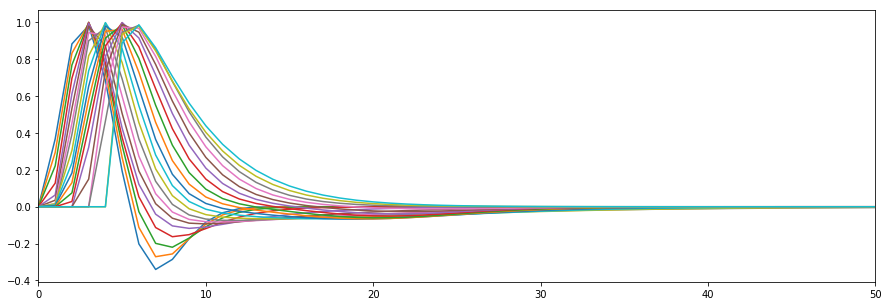

In [6]:
from scipy.io import loadmat
from scipy.interpolate import interp1d

hrf_ts = loadmat('../pybest/data/hrf_ts.mat')['hrf_ts']
t = np.linspace(0, 50, hrf_ts.shape[0], endpoint=True)
f = interp1d(t, hrf_ts, axis=0)
t_low = np.linspace(0, 50, 51, endpoint=True)
hrf_ds = f(t_low)

plt.figure(figsize=(15, 5))
#plt.plot(t, hrf_ts)
plt.plot(t_low, hrf_ds)
plt.xlim(0, 50)

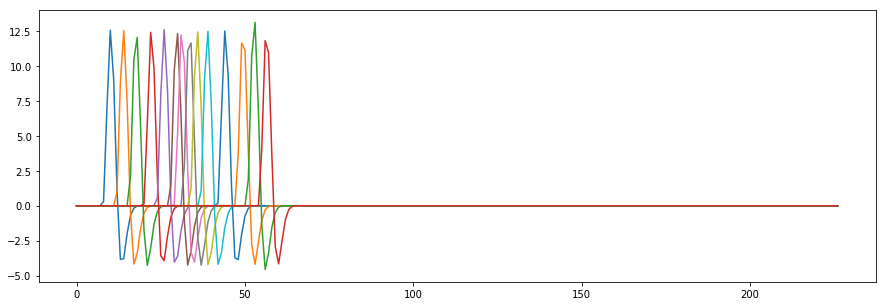

In [54]:
T = 300
TR = 1.317
OSF = TR / 0.1
dur = 1.25
hr_ft = np.linspace(0, T, int(T / (TR / OSF)), endpoint=False)
onsets = np.array([10, 15, 20, 26, 31, 36, 38, 41, 44, 48, 55, 62, 66.3, 71.2])
hr_reg = np.zeros((hr_ft.size, onsets.size))
for i, o in enumerate(onsets):
    min_idx = int(np.round(np.abs(hr_ft - o).argmin()))
    end_idx = int(np.round(min_idx + (dur * OSF / TR)))
    hr_reg[min_idx:(end_idx + 1), i] = 1

plt.figure(figsize=(15, 5))
t = np.linspace(0, T, int(T / TR), endpoint=False)
for i in range(hr_reg.shape[1]):
    conv = np.convolve(hr_reg[:, i], hrf_ts[:, 0])[:hr_reg.shape[0]]
    f = interp1d(hr_ft, conv)
    plt.plot(f(t))